# Análisis de Tarifas de Megaline

## Objetivo
El objetivo de este proyecto es analizar el comportamiento de los clientes de Megaline para determinar cuál de sus dos tarifas de prepago (Surf y Ultimate) genera más ingresos. Para ello, realizaremos un análisis estadístico sobre los datos de uso de llamadas, mensajes y datos de internet de los clientes.

## Carga y Preprocesamiento de Datos
Cargamos los datos proporcionados en formato CSV y realizamos la conversión de fechas a un formato adecuado para su manipulación.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# Cargar los datasets ficticios
df_users = pd.read_csv("megaline_users.csv")
df_calls = pd.read_csv("megaline_calls.csv")
df_messages = pd.read_csv("megaline_messages.csv")
df_internet = pd.read_csv("megaline_internet.csv")
df_plans = pd.read_csv("megaline_plans.csv")

## 0. Exploración
Lo habitual...

In [3]:
df_users.head()

,user_id,plan,city,reg_date,churn_date
0,1,Surf,New York,2018-01-01 00:00:00.000000000,NaN
1,2,Ultimate,New York,2018-01-01 08:39:26.332665330,NaN
2,3,Ultimate,New York,2018-01-01 17:18:52.665330661,NaN
3,4,Surf,Phoenix,2018-01-02 01:58:18.997995991,NaN
4,5,Surf,Houston,2018-01-02 10:37:45.330661322,NaN


In [4]:
df_calls.head()

,id,call_date,duration,user_id
0,1,2018-01-01 00:00:00.000000000,15,35
1,2,2018-01-01 01:44:51.178235647,15,24
2,3,2018-01-01 03:29:42.356471294,6,28
3,4,2018-01-01 05:14:33.534706941,12,484
4,5,2018-01-01 06:59:24.712942588,18,464


In [5]:
df_messages.head()

,id,message_date,user_id
0,1,2018-01-01 00:00:00.000000000,322
1,2,2018-01-01 04:22:12.666333166,397
2,3,2018-01-01 08:44:25.332666333,318
3,4,2018-01-01 13:06:37.998999499,54
4,5,2018-01-01 17:28:50.665332666,399


In [6]:
df_internet.head()

,id,session_date,mb_used,user_id
0,1,2018-01-01 00:00:00.000000000,1338,142
1,2,2018-01-01 02:54:46.695565188,1856,46
2,3,2018-01-01 05:49:33.391130376,1054,163
3,4,2018-01-01 08:44:20.086695565,2406,285
4,5,2018-01-01 11:39:06.782260753,2925,268


In [7]:
df_plans.head()

,plan_name,usd_monthly_fee,minutes_included,messages_included,mb_per_month_included,usd_per_minute,usd_per_message,usd_per_gb
0,Surf,20,500,50,15360,0.03,0.03,10
1,Ultimate,70,3000,1000,30720,0.01,0.01,7


In [8]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5000 non-null   int64 
 1   call_date  5000 non-null   object
 2   duration   5000 non-null   int64 
 3   user_id    5000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 156.4+ KB


In [9]:
df_calls.head()

,id,call_date,duration,user_id
0,1,2018-01-01 00:00:00.000000000,15,35
1,2,2018-01-01 01:44:51.178235647,15,24
2,3,2018-01-01 03:29:42.356471294,6,28
3,4,2018-01-01 05:14:33.534706941,12,484
4,5,2018-01-01 06:59:24.712942588,18,464


In [10]:
df_calls['call_date'].unique()

array(['2018-01-01 00:00:00.000000000', '2018-01-01 01:44:51.178235647',
       '2018-01-01 03:29:42.356471294', ...,
       '2018-12-30 20:30:17.643528708', '2018-12-30 22:15:08.821764356',
       '2018-12-31 00:00:00.000000000'], dtype=object)

## 1. Convertir fechas a formato datetime
Nos será de utilidad más adelante

In [11]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

In [12]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         5000 non-null   int64         
 1   call_date  5000 non-null   datetime64[ns]
 2   duration   5000 non-null   int64         
 3   user_id    5000 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 156.4 KB


In [13]:
df_calls.head()

,id,call_date,duration,user_id
0,1,2018-01-01 00:00:00.000000000,15,35
1,2,2018-01-01 01:44:51.178235647,15,24
2,3,2018-01-01 03:29:42.356471294,6,28
3,4,2018-01-01 05:14:33.534706941,12,484
4,5,2018-01-01 06:59:24.712942588,18,464


In [14]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

## 2. Análisis del Comportamiento de Clientes
Queremos entender cómo los clientes utilizan los servicios de Megaline en términos de:
- Minutos de llamadas realizadas
- SMS enviados
- Datos consumidos

In [15]:
df_calls['month'] = df_calls['call_date'].dt.month

In [16]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         5000 non-null   int64         
 1   call_date  5000 non-null   datetime64[ns]
 2   duration   5000 non-null   int64         
 3   user_id    5000 non-null   int64         
 4   month      5000 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(3)
memory usage: 175.9 KB


In [17]:
df_calls.head()

,id,call_date,duration,user_id,month
0,1,2018-01-01 00:00:00.000000000,15,35,1
1,2,2018-01-01 01:44:51.178235647,15,24,1
2,3,2018-01-01 03:29:42.356471294,6,28,1
3,4,2018-01-01 05:14:33.534706941,12,484,1
4,5,2018-01-01 06:59:24.712942588,18,464,1


In [18]:
# Extraer el mes de cada transacción
df_messages['month'] = df_messages['message_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month

## 3. Agrupando información relevante

In [19]:
df_calls.head(7)

,id,call_date,duration,user_id,month
0,1,2018-01-01 00:00:00.000000000,15,35,1
1,2,2018-01-01 01:44:51.178235647,15,24,1
2,3,2018-01-01 03:29:42.356471294,6,28,1
3,4,2018-01-01 05:14:33.534706941,12,484,1
4,5,2018-01-01 06:59:24.712942588,18,464,1
5,6,2018-01-01 08:44:15.891178235,14,488,1
6,7,2018-01-01 10:29:07.069413882,2,16,1


In [20]:
calls_per_user = df_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
calls_per_user.head()

,user_id,month,duration
0,1,1,16
1,1,2,13
2,1,6,23
3,1,9,19
4,1,11,8


In [21]:
# Agregar el total mensual por usuario
messages_per_user = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_per_user.head()

,user_id,month,id
0,1,5,1
1,1,7,1
2,2,4,1
3,2,7,1
4,2,11,1


In [22]:
internet_per_user = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_per_user.head()

,user_id,month,mb_used
0,1,1,2216
1,1,3,2698
2,1,5,1085
3,1,6,689
4,1,7,599


## 4. Unión de dataframes

In [23]:
df_users.head()

,user_id,plan,city,reg_date,churn_date
0,1,Surf,New York,2018-01-01 00:00:00.000000000,NaN
1,2,Ultimate,New York,2018-01-01 08:39:26.332665330,NaN
2,3,Ultimate,New York,2018-01-01 17:18:52.665330661,NaN
3,4,Surf,Phoenix,2018-01-02 01:58:18.997995991,NaN
4,5,Surf,Houston,2018-01-02 10:37:45.330661322,NaN


In [24]:
df_users_plans = df_users[['user_id', 'plan']]
df_users_plans.head()

,user_id,plan
0,1,Surf
1,2,Ultimate
2,3,Ultimate
3,4,Surf
4,5,Surf


In [25]:
calls_per_user = calls_per_user.merge(df_users_plans, on='user_id', how='left')
calls_per_user.head()

,user_id,month,duration,plan
0,1,1,16,Surf
1,1,2,13,Surf
2,1,6,23,Surf
3,1,9,19,Surf
4,1,11,8,Surf


In [26]:
messages_per_user = messages_per_user.merge(df_users_plans, on='user_id', how='left')
messages_per_user.head()

,user_id,month,id,plan
0,1,5,1,Surf
1,1,7,1,Surf
2,2,4,1,Ultimate
3,2,7,1,Ultimate
4,2,11,1,Ultimate


In [27]:
internet_per_user = internet_per_user.merge(df_users_plans, on='user_id', how='left')
internet_per_user.head()

,user_id,month,mb_used,plan
0,1,1,2216,Surf
1,1,3,2698,Surf
2,1,5,1085,Surf
3,1,6,689,Surf
4,1,7,599,Surf


## 5. Cálculo de Ingresos Mensuales
Cada usuario genera ingresos mensuales según su tarifa y su consumo adicional sobre los límites del plan. 

In [52]:
def calcular_ingresos(row):
    plan = df_plans[df_plans['plan_name'] == row['plan']].iloc[0]
    extra_minutes = max(row['duration'] - plan['minutes_included'], 0)
    extra_messages = max(row['id'] - plan['messages_included'], 0)
    extra_data = max(row['mb_used'] - plan['mb_per_month_included'], 0) / 1024
    
    ingresos = (plan['usd_monthly_fee'] +
                extra_minutes * plan['usd_per_minute'] +
                extra_messages * plan['usd_per_message'] +
                np.ceil(extra_data) * plan['usd_per_gb'])
    return ingresos

_Revisando la forma cómo se tienen organizados los dataframes actualmente. ¿No crees que nos falta un paso adicional?_

## 6. Combinando las agrupaciones

In [29]:
df_usuarios_mensuales = calls_per_user.merge(messages_per_user, on=['user_id', 'month', 'plan'], how='outer')
df_usuarios_mensuales = df_usuarios_mensuales.merge(internet_per_user, on=['user_id', 'month', 'plan'], how='outer')

In [30]:
df_usuarios_mensuales.head()

,user_id,month,duration,plan,id,mb_used
0,1,1,16.0,Surf,NaN,2216.0
1,1,2,13.0,Surf,NaN,NaN
2,1,3,NaN,Surf,NaN,2698.0
3,1,5,NaN,Surf,1.0,1085.0
4,1,6,23.0,Surf,NaN,689.0


In [32]:
df_usuarios_mensuales = df_usuarios_mensuales.fillna(0)

In [33]:
df_usuarios_mensuales.head()

,user_id,month,duration,plan,id,mb_used
0,1,1,16.0,Surf,0.0,2216.0
1,1,2,13.0,Surf,0.0,0.0
2,1,3,0.0,Surf,0.0,2698.0
3,1,5,0.0,Surf,1.0,1085.0
4,1,6,23.0,Surf,0.0,689.0


## 7. Calculando ingreso mensual en un unico df

In [53]:
df_usuarios_mensuales['revenue'] = df_usuarios_mensuales.apply(calcular_ingresos, axis=1)

In [38]:
df_plans['plan'] = df_plans['plan_name']

In [39]:
df_usuarios_mensuales = df_usuarios_mensuales.merge(df_plans, on=['plan'], how='outer')

In [54]:
df_usuarios_mensuales.head()

,user_id,month,duration,plan,id,mb_used,plan_name,usd_monthly_fee,minutes_included,messages_included,mb_per_month_included,usd_per_minute,usd_per_message,usd_per_gb,cobro_minutos_2,cobro_minutos_3,revenue
0,1,1,16.0,Surf,0.0,2216.0,Surf,20,500,50,15360,0.03,0.03,10,-484.0,0,20.0
1,1,2,13.0,Surf,0.0,0.0,Surf,20,500,50,15360,0.03,0.03,10,-487.0,0,20.0
2,1,3,0.0,Surf,0.0,2698.0,Surf,20,500,50,15360,0.03,0.03,10,-500.0,0,20.0
3,1,5,0.0,Surf,1.0,1085.0,Surf,20,500,50,15360,0.03,0.03,10,-500.0,0,20.0
4,1,6,23.0,Surf,0.0,689.0,Surf,20,500,50,15360,0.03,0.03,10,-477.0,0,20.0


In [48]:
def limpiar_calculo(calculo):
    if calculo > 0:
        calculo = calculo
    else:
        calculo = 0
    return calculo

In [49]:
df_usuarios_mensuales['cobro_minutos_3'] = df_usuarios_mensuales['cobro_minutos_2'].apply(limpiar_calculo)

In [51]:
df_usuarios_mensuales['cobro_minutos_3'].unique()

array([0], dtype=int64)

## 8. Visualización de la Distribución de Ingresos
Analizamos la distribución de ingresos para evaluar la diferencia entre los planes.

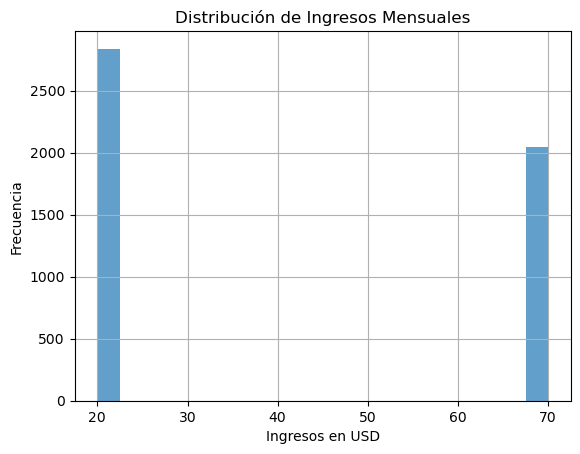

In [14]:
df_usuarios_mensuales['revenue'].hist(bins=20, alpha=0.7)
plt.title("Distribución de Ingresos Mensuales")
plt.xlabel("Ingresos en USD")
plt.ylabel("Frecuencia")
plt.show()

**Explicación:** El histograma nos muestra la cantidad de clientes agrupados según sus ingresos mensuales. Podemos observar si hay diferencias significativas entre los clientes de cada plan.

## 9. Pruebas de Hipótesis
Queremos verificar si existe una diferencia significativa en los ingresos generados por los planes *Surf* y *Ultimate*.

In [15]:
test_results = st.ttest_ind(df_usuarios_mensuales[df_usuarios_mensuales['plan'] == 'Surf']['revenue'],
                            df_usuarios_mensuales[df_usuarios_mensuales['plan'] == 'Ultimate']['revenue'])
print("Valor p de la prueba t para comparar ingresos entre planes:", test_results.pvalue)

Valor p de la prueba t para comparar ingresos entre planes: 0.0


C:\Users\ljpca\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


**Interpretación del resultado:**
- Si el valor p es menor a 0.05, podemos concluir que los ingresos promedio entre los dos planes son significativamente diferentes.
- Si el valor p es mayor a 0.05, no hay suficiente evidencia para decir que un plan genera más ingresos que el otro.

## **Conclusión**
Este análisis nos permite entender el comportamiento de los clientes de Megaline y evaluar cuál de los planes genera mayores ingresos. Con base en los resultados, la empresa podrá ajustar su presupuesto de publicidad y estrategias de marketing para maximizar sus ganancias.
